# Transfer learning and fine-tuning

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [3]:
train_dir = "Train/"
validation_dir = "Test/"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 675 files belonging to 2 classes.


/home/preethika/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [4]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 156 files belonging to 2 classes.


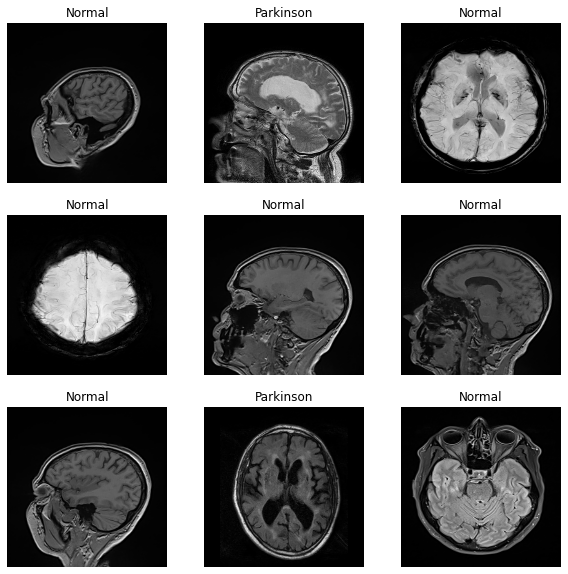

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [9]:
print(tf.__version__)

2.10.0


In [13]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.random_flip_left_right('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])
data_augmentation = tf.keras.Sequential([
# 	preprocessing.Rescaling(scale=1.0 / 255),
	tf.keras.layers.RandomFlip("horizontal"),
	tf.keras.layers.RandomRotation(0.2)
])

# data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
#    rotation_range=30, horizontal_flip=True)

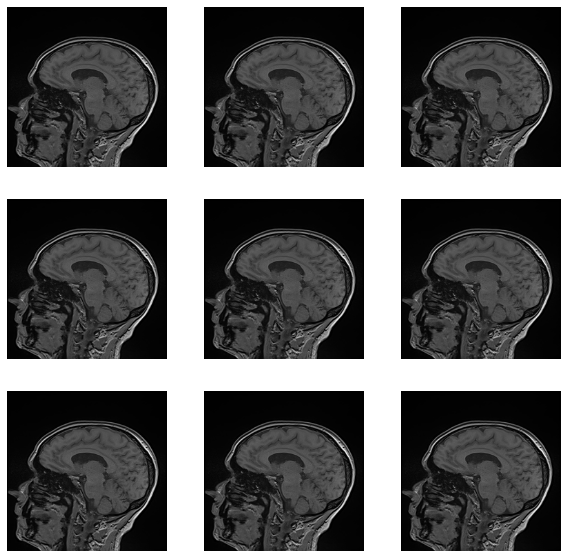

In [48]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
#   print(image[1])
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # from [0, 255] to [-1, 1]

## Base model 

In [17]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [49]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
# print(feature_batch.shape)

## Feature extraction


In [19]:
base_model.trainable = False # freeze conv layer

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [52]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [53]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [25]:
# Building model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Training

In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 3s 620ms/step - loss: 0.7865 - accuracy: 0.5968


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.60


In [31]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
 8/22 [=========>....................] - ETA: 39s - loss: 0.7397 - accuracy: 0.6719WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


17/22 [======================>.......] - ETA: 13s - loss: 0.7145 - accuracy: 0.6654WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 60s 3s/step - loss: 0.6914 - accuracy: 0.6741 - val_loss: 0.6506 - val_accuracy: 0.7581
Epoch 2/10
 4/22 [====>.........................] - ETA: 48s - loss: 0.6263 - accuracy: 0.7109WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


13/22 [================>.............] - ETA: 23s - loss: 0.6337 - accuracy: 0.7163WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 59s 3s/step - loss: 0.6265 - accuracy: 0.7111 - val_loss: 0.6577 - val_accuracy: 0.7581
Epoch 3/10


 9/22 [===========>..................] - ETA: 36s - loss: 0.5987 - accuracy: 0.7118WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


18/22 [=======================>......] - ETA: 11s - loss: 0.5789 - accuracy: 0.7240WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 63s 3s/step - loss: 0.5852 - accuracy: 0.7244 - val_loss: 0.7233 - val_accuracy: 0.7097
Epoch 4/10
 5/22 [=====>........................] - ETA: 47s - loss: 0.5070 - accuracy: 0.7375WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


14/22 [==================>...........] - ETA: 22s - loss: 0.5366 - accuracy: 0.7232WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 63s 3s/step - loss: 0.5554 - accuracy: 0.7215 - val_loss: 0.6662 - val_accuracy: 0.7581
Epoch 5/10
 1/22 [>.............................] - ETA: 1:00 - loss: 0.3445 - accuracy: 0.8125WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


10/22 [============>.................] - ETA: 33s - loss: 0.5291 - accuracy: 0.7375WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


19/22 [========================>.....] - ETA: 8s - loss: 0.5179 - accuracy: 0.7451 WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 63s 3s/step - loss: 0.5177 - accuracy: 0.7422 - val_loss: 0.6825 - val_accuracy: 0.7581
Epoch 6/10
 6/22 [=======>......................] - ETA: 44s - loss: 0.5072 - accuracy: 0.7812WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


15/22 [===================>..........] - ETA: 19s - loss: 0.5261 - accuracy: 0.7417WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 63s 3s/step - loss: 0.5237 - accuracy: 0.7422 - val_loss: 0.6881 - val_accuracy: 0.7661
Epoch 7/10
 2/22 [=>............................] - ETA: 57s - loss: 0.5151 - accuracy: 0.7500 WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


11/22 [==============>...............] - ETA: 31s - loss: 0.5096 - accuracy: 0.7358WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


20/22 [==========================>...] - ETA: 5s - loss: 0.4915 - accuracy: 0.7547WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 65s 3s/step - loss: 0.4957 - accuracy: 0.7481 - val_loss: 0.7100 - val_accuracy: 0.7419
Epoch 8/10
 7/22 [========>.....................] - ETA: 43s - loss: 0.5169 - accuracy: 0.7545WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


16/22 [====================>.........] - ETA: 16s - loss: 0.4821 - accuracy: 0.7656WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 62s 3s/step - loss: 0.4812 - accuracy: 0.7615 - val_loss: 0.6982 - val_accuracy: 0.7419
Epoch 9/10
 3/22 [===>..........................] - ETA: 52s - loss: 0.4520 - accuracy: 0.8229WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


12/22 [===============>..............] - ETA: 25s - loss: 0.4682 - accuracy: 0.7734WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


21/22 [===========================>..] - ETA: 2s - loss: 0.4646 - accuracy: 0.7664WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 57s 3s/step - loss: 0.4652 - accuracy: 0.7659 - val_loss: 0.6984 - val_accuracy: 0.7339
Epoch 10/10
 8/22 [=========>....................] - ETA: 36s - loss: 0.4254 - accuracy: 0.8008WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


17/22 [======================>.......] - ETA: 12s - loss: 0.4266 - accuracy: 0.7886WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 58s 3s/step - loss: 0.4332 - accuracy: 0.7881 - val_loss: 0.7251 - val_accuracy: 0.7581


Text(0.5, 1.0, 'Training and Validation Accuracy')

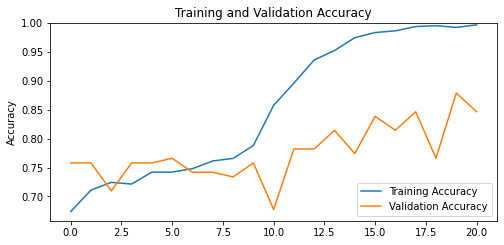

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

## Fine tuning

In [33]:
base_model.trainable = True #unfreeze top layer

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [35]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
 8/22 [=========>....................] - ETA: 41s - loss: 0.3753 - accuracy: 0.8242WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


17/22 [======================>.......] - ETA: 15s - loss: 0.3398 - accuracy: 0.8511WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 66s 3s/step - loss: 0.3291 - accuracy: 0.8578 - val_loss: 0.6704 - val_accuracy: 0.6774
Epoch 11/20
 4/22 [====>.........................] - ETA: 47s - loss: 0.2622 - accuracy: 0.8594WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


13/22 [================>.............] - ETA: 23s - loss: 0.2512 - accuracy: 0.8702WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 59s 3s/step - loss: 0.2113 - accuracy: 0.8963 - val_loss: 0.5779 - val_accuracy: 0.7823
Epoch 12/20


 9/22 [===========>..................] - ETA: 36s - loss: 0.1432 - accuracy: 0.9410WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


18/22 [=======================>......] - ETA: 11s - loss: 0.1495 - accuracy: 0.9323WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 62s 3s/step - loss: 0.1446 - accuracy: 0.9363 - val_loss: 0.4427 - val_accuracy: 0.7823
Epoch 13/20
 5/22 [=====>........................] - ETA: 46s - loss: 0.1107 - accuracy: 0.9375WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


14/22 [==================>...........] - ETA: 21s - loss: 0.1099 - accuracy: 0.9509WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 61s 3s/step - loss: 0.1126 - accuracy: 0.9526 - val_loss: 0.3820 - val_accuracy: 0.8145
Epoch 14/20
 1/22 [>.............................] - ETA: 58s - loss: 0.1146 - accuracy: 0.9375WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


10/22 [============>.................] - ETA: 32s - loss: 0.0776 - accuracy: 0.9781WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


19/22 [========================>.....] - ETA: 8s - loss: 0.0770 - accuracy: 0.9770 WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 61s 3s/step - loss: 0.0783 - accuracy: 0.9748 - val_loss: 0.4924 - val_accuracy: 0.7742
Epoch 15/20
 6/22 [=======>......................] - ETA: 44s - loss: 0.0890 - accuracy: 0.9688WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


15/22 [===================>..........] - ETA: 18s - loss: 0.0664 - accuracy: 0.9833WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 60s 3s/step - loss: 0.0648 - accuracy: 0.9837 - val_loss: 0.3832 - val_accuracy: 0.8387
Epoch 16/20
 2/22 [=>............................] - ETA: 52s - loss: 0.0272 - accuracy: 1.0000WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


11/22 [==============>...............] - ETA: 28s - loss: 0.0405 - accuracy: 0.9915WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


20/22 [==========================>...] - ETA: 5s - loss: 0.0429 - accuracy: 0.9891WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 60s 3s/step - loss: 0.0451 - accuracy: 0.9867 - val_loss: 0.4314 - val_accuracy: 0.8145
Epoch 17/20
 7/22 [========>.....................] - ETA: 39s - loss: 0.0369 - accuracy: 0.9911WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


16/22 [====================>.........] - ETA: 16s - loss: 0.0305 - accuracy: 0.9941WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 60s 3s/step - loss: 0.0319 - accuracy: 0.9941 - val_loss: 0.3319 - val_accuracy: 0.8468
Epoch 18/20
 3/22 [===>..........................] - ETA: 51s - loss: 0.0284 - accuracy: 0.9896WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


12/22 [===============>..............] - ETA: 26s - loss: 0.0232 - accuracy: 0.9974WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


21/22 [===========================>..] - ETA: 2s - loss: 0.0254 - accuracy: 0.9955WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 60s 3s/step - loss: 0.0252 - accuracy: 0.9956 - val_loss: 0.5978 - val_accuracy: 0.7661
Epoch 19/20
 8/22 [=========>....................] - ETA: 36s - loss: 0.0162 - accuracy: 0.9922WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


17/22 [======================>.......] - ETA: 13s - loss: 0.0210 - accuracy: 0.9908WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 60s 3s/step - loss: 0.0193 - accuracy: 0.9926 - val_loss: 0.2679 - val_accuracy: 0.8790
Epoch 20/20
 4/22 [====>.........................] - ETA: 49s - loss: 0.0081 - accuracy: 1.0000WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


13/22 [================>.............] - ETA: 25s - loss: 0.0157 - accuracy: 0.9976WARNING:tensorflow:It looks like tf.function behavior was disabled, perhaps using tf.config.run_functions_eagerly. Vectorization primitives (e.g. tf.vectorized_map) require tf.function to work. These primitives will override the disable.


22/22 [==============================] - 63s 3s/step - loss: 0.0153 - accuracy: 0.9970 - val_loss: 0.3143 - val_accuracy: 0.8468


In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

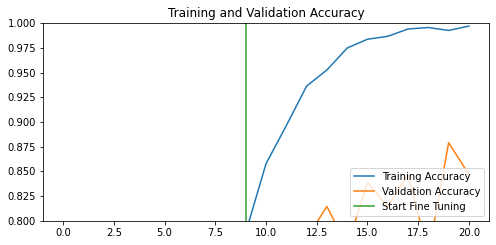

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [47]:
model.save("tranfer_learning.h5")

### Evaluation and prediction

In [40]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 748ms/step - loss: 0.4285 - accuracy: 0.7812
Test accuracy : 0.78125


Predictions:
 [1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0]
Labels:
 [1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0]


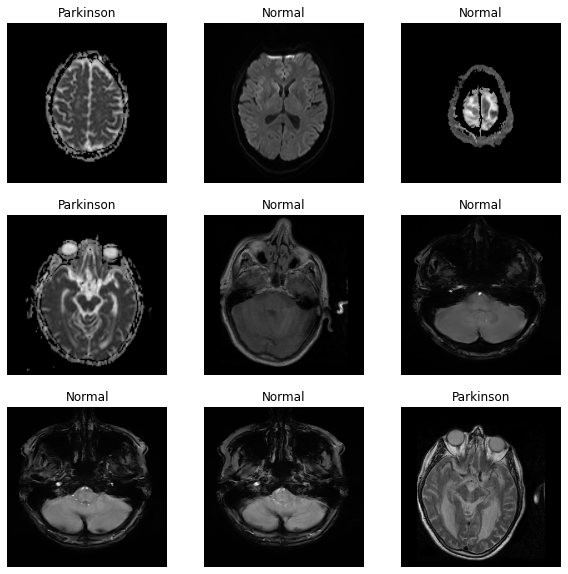

In [41]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")